In [72]:
from time import time
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
from batchgenerators.dataloading import MultiThreadedAugmenter
from batchgenerators.examples.brats2017.brats2017_dataloader_3D import get_list_of_patients, BraTS2017DataLoader3D, \
    get_train_transform
from batchgenerators.examples.brats2017.config import brats_preprocessed_folder, num_threads_for_brats_example
from batchgenerators.transforms import Compose
from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.utilities.file_and_folder_operations import *
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import Mirror
from batchgenerators.transforms.abstract_transforms import Compose

import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from nibabel.testing import data_path
import nibabel as nib
import random 

ImportError: cannot import name 'Mirror'

In [73]:

class BraTS2017DataLoader2D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, seed_for_shuffle=1234, return_incomplete=False,
                 shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)

        patch_size is the spatial size the retured batch will have

        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        self.patch_size = patch_size
        self.num_modalities = 4
        self.indices = list(range(len(data)))

    @staticmethod
    def load_patient(patient):
        return BraTS2017DataLoader3D.load_patient(patient)

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data[i] for i in idx]

        # initialize empty array for data and seg
        data = np.zeros((self.batch_size, self.num_modalities, *self.patch_size), dtype=np.float32)
        seg = np.zeros((self.batch_size, 1, *self.patch_size), dtype=np.float32)

        metadata = []
        patient_names = []

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data, patient_metadata = self.load_patient(j)
            #print(" patient_data shape ",str(patient_data.shape))
            # patient data is a memmap. If we extract just one slice then just this one slice will be read from the
            # disk, so no worries!
            #slice_idx = np.random.choice(patient_data.shape[1])
            #print(" slice_idx  ",slice_idx)
            startIdx = 60
            endIdx = 80
            slice_idx = np.random.randint(startIdx,endIdx)
            #patient_data = patient_data[:, slice_idx]
            patient_data = patient_data[:, slice_idx]

            # this will only pad patient_data if its shape is smaller than self.patch_size
            patient_data = pad_nd_image(patient_data, self.patch_size)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            patient_data, patient_seg = crop(patient_data[:-1][None], patient_data[-1:][None], self.patch_size, crop_type="random")

            data[i] = patient_data[0]
            seg[i] = patient_seg[0]

            metadata.append(patient_metadata)
            patient_names.append(j)

        return {'data': data, 'seg':seg, 'metadata':metadata, 'names':patient_names}


In [74]:
patients = get_list_of_patients(brats_preprocessed_folder)
train, val = get_split_deterministic(patients, fold=0, num_splits=2, random_state=12345)
patch_size = (160, 160)
batch_size = 10


In [75]:
def plot_batch(batch):
    batch_size = batch['data'].shape[0]
    print("batch_size :",batch_size)
    plt.figure(figsize=(80, 80))
    for i in range(0,8,2):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(batch['data'][i, 0], cmap="gray") # only grayscale image here
        plt.subplot(1, batch_size, i+2)
        plt.imshow(batch['seg'][i, 0], cmap="gray") 
    plt.show()

batch_size : 10


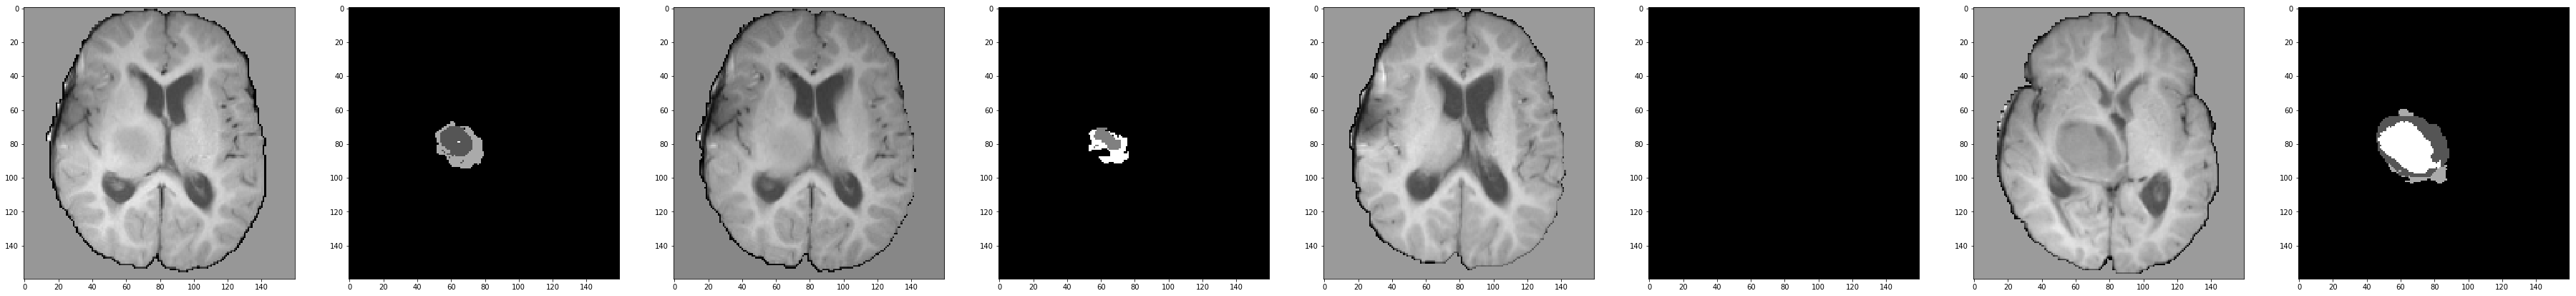

In [76]:
# I recommend you don't use 'iteration oder all training data' as epoch because in patch based training this is
# really not super well defined. If you leave all arguments as default then each batch sill contain randomly
# selected patients. Since we don't care about epochs here we can set num_threads_in_multithreaded to anything.
dataloader = BraTS2017DataLoader2D(train, batch_size, patch_size, 1)
batch = next(dataloader)
plot_batch(batch)

In [83]:
from batchgenerators.transforms import Compose, MirrorTransform
tranform_list1 = [# CenterCropTransform(crop_size=target_size),
                         MirrorTransform(axes=(0,2)),
                         ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
                         ]

all_transforms1 = Compose(tranform_list1)

batch_size : 10


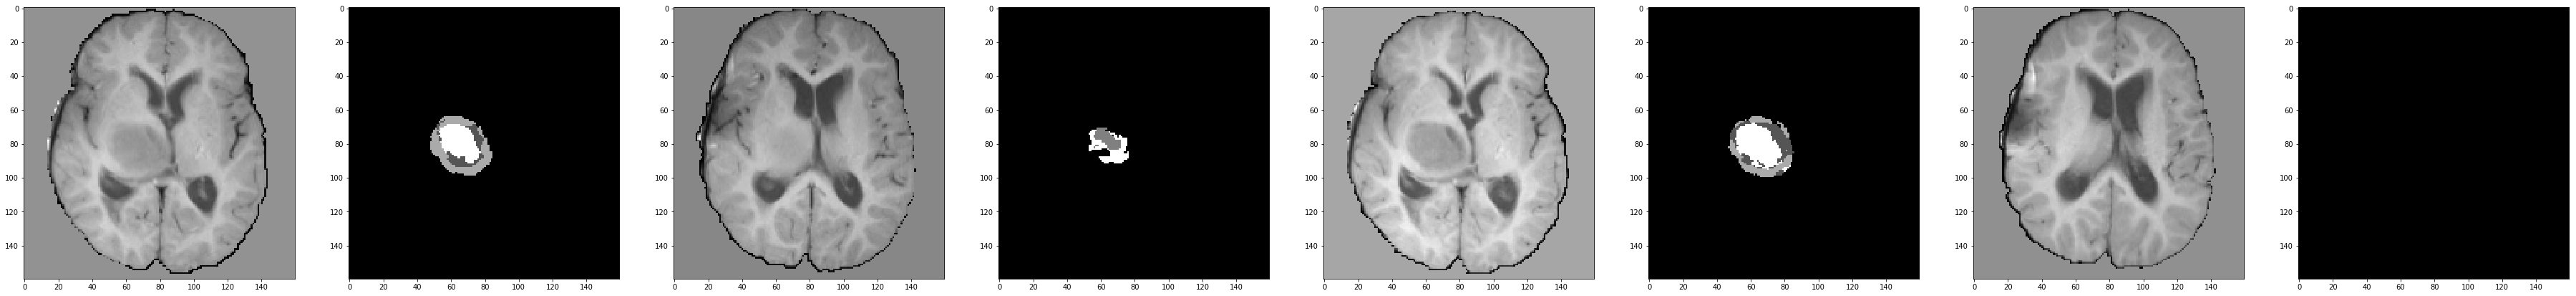

In [85]:
multithreaded_generator_hipp1 = MultiThreadedAugmenter(batch, all_transforms1, 4, 2, seeds=None)
# you can run this line several times to see different outputs
plot_batch(next(dataloader))